# 1. Setup

## 1.1 Summary

### <span style="color: #e74c3c;">**k-Nearest Neighbours Implementation Summary**</span>

This notebook applies **k-Nearest Neighbours (k-NN)** to predict student withdrawal risk from a pre-processed student data set.

### <span style="color: #2E86AB;">**1.1a Algorithm Overview**</span>

*k-NN* is a **non-parametric** (does not assume a fixed functional form) and **instance-based** (stores all training instances) learning algorithm that:

- measures similarity between a new case and the training set (typically with Euclidean distance);  
- selects the *k* closest neighbours;  
- assigns the class label by majority vote among those neighbours.

Because decision boundaries are formed locally, the model adapts to small-scale structure in the data.

### <span style="color: #2E86AB;">**1.1b Binary Classification Setup**</span>

The original three-class outcome is collapsed to a binary label:

- **Continuation** (1) – combines “Graduate” and “Enrolled”;  
- **Withdrawn** (0) – retains the original “Dropout”.

This yields a moderately imbalanced yet manageable class distribution for majority voting.

### <span style="color: #2E86AB;">**1.1c Pre-processing Requirements**</span>

To ensure distance calculations are meaningful:

- **Feature scaling** – `StandardScaler` rescales each feature to zero mean and unit variance;  
- **One-hot encoding** – converts categorical attributes to binary indicator columns;  
- **Feature selection** – removes redundant or low-informative attributes identified during exploratory analysis.

### <span style="color: #2E86AB;">**1.1d Model Configuration**</span>

Key hyper-parameters:

- **Neighbour count** *k* – odd values preferred to avoid ties;  
- **Distance metric** – Euclidean for continuous features;  
- **Voting weights** – uniform vs. distance-weighted;  
- **Centralised configuration file** – a `config.toml` file stores all tunable parameters (e.g., `n_neighbors_range`, `cv`, `scoring`). Editing a single file enables rapid, reproducible experimentation without touching code.

A grid search with cross-validation will locate the optimal combination.

### <span style="color: #e74c3c;">**1.1e Expected Outcomes**</span>

We will assess how well k-NN distinguishes at-risk students and compare its performance with a logistic-regression baseline, paying particular attention to the algorithm’s sensitivity to feature scaling and the choice of *k*.


## 1.2 Libraries Import

In [397]:
# Project utilities
from tools import Tools

# Standard library
import random

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# scikit-learn – data prep & modelling
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# scikit-learn – evaluation
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
)


In [398]:
# Set random seeds for full reproducibility
np.random.seed(42)
random.seed(42)
print("✅ Random seeds set for reproducibility")

✅ Random seeds set for reproducibility


## 1.3 Invoke Classes

In [399]:
tools = Tools()

## 1.4 Load Configuration

In [400]:
config = tools.load_toml_file("config.toml")
knn_config = config.get('k-NN_model', {})
tools.print_message('success', 'Loaded configuration', format_dict={'number of keys': len(config)})

>>> ✅ SUCCESS!: Loaded configuration NUMBER OF KEYS: 6

## 1.5 Load the dataset

In [401]:
# Open dataset
# Realinho, V., Martins, M.V., Machado, J. and Baptista, L.M.T., 2021. Predict Students' Dropout and Academic Success. UCI Machine Learning Repository. Available at: https://doi.org/10.24432/C5MC89 [Accessed 31 May 2025].
df_dataset = tools.load_dataset(file_name='dataset_raw.csv')
df_dataset.head()

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nationality,mothers_qualification,fathers_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## 1.6 Apply Target Binary Transformation

In [402]:
# Add a new target column with renamed values for one vs rest classification
df_dataset['target_binary'] = df_dataset['target'].map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 1})
df_dataset['target_binary'].value_counts()

target_binary
1    3003
0    1421
Name: count, dtype: int64

## 1.7 Data Shape Check

In [403]:
shape = df_dataset.shape
tools.print_message('success', 'Dataset loaded', format_dict={'rows': shape[0], 'columns': shape[1]})

>>> ✅ SUCCESS!: Dataset loaded ROWS: 4424, COLUMNS: 38

# 2. Feature Selection

## 2.1 Summary

### <span style="color: #e74c3c;">**2.1a Feature Selection for k-Nearest Neighbours**</span>

Section 2 distils the raw data into a lean, high-signal feature set for k-NN, addressing data-leakage, multicollinearity and dimensionality challenges.

### <span style="color: #2E86AB;">**2.1b Data-Leakage Safeguards**</span>

All second-semester metrics are excluded—those values exist only *after* a withdrawal and would let k-NN “peek at the future”. Only first-semester and pre-enrolment information remains, ensuring the model’s early-warning claims are genuine.

### <span style="color: #2E86AB;">**2.1c Multicollinearity Fixes**</span>

Variance Inflation Factor (VIF) analysis shows first-semester unit-count features to be redundant. Dropping them and keeping **curricular_units_1st_sem_grade** prevents tightly linked dimensions from distorting Euclidean distances.

### <span style="color: #2E86AB;">**2.1d Taming High-Cardinality Categoricals**</span>

* **Parental background** → two binary flags (*parental_higher_education*, *parental_professional_occupation*) replace dozens of raw codes.  
* **Academic context** → target-encoded risk scores (*course_withdrawal_rate*, *application_mode_withdrawal_rate*) stand in for many course and application-mode categories.  

Both moves slash dimensionality while retaining predictive signal.

### <span style="color: #2E86AB;">**2.1e Noise Pruning**</span>

Features with extreme class imbalance (e.g., *nationality*, *educational_special_needs*) or negligible association with withdrawal (macro-economic stats, previous qualification grade) are removed to reduce noise and computation.

### <span style="color: #e74c3c;">**2.1f Why a ~10-Feature Core Works**</span>

* **Dimensionality** – fewer axes keep neighbours meaningfully close.  
* **Speed** – distance calculations and hyper-parameter searches remain fast.  
* **Transparency** – each retained attribute has a clear, domain-based rationale.

### <span style="color: #2E86AB;">**2.1g Final Feature Line-Up**</span>

| Category | Features kept |
| --- | --- |
| **Financial** | tuition_fees_up_to_date, scholarship_holder |
| **Academic context** | course_withdrawal_rate, application_mode_withdrawal_rate, application_order |
| **Performance** | curricular_units_1st_sem_grade, age_at_enrollment |
| **Background** | parental_higher_education, parental_professional_occupation |
| **Pre-enrolment** | admission_grade |


## 2.2 Features to Remove

In [404]:
# Severe class imbalance makes these features uninformative
uninformative_categorical = [
    'nationality',                    # 97.5% Portuguese - no variation
    'educational_special_needs',      # 98.9% no special needs - no variation
    'international',                  # 97.5% domestic - no variation
    'displaced',                      # Zero mutual information with target
    'daytime_evening_attendance'      # Zero mutual information with target
]

# Very weak correlation with target variable makes these unhelpful
weak_economic_features = [
    'unemployment_rate',              # -0.03 correlation - essentially no relationship
    'inflation_rate',                 # 0.02 correlation - essentially no relationship
    'gdp'                            # 0.05 correlation - essentially no relationship
]

# Data leakage - using information that only exists after the outcome has occurred
second_semester_remove = [
    'curricular_units_2nd_sem_grade',           # VIF 5.46 but still data leakage
    'curricular_units_2nd_sem_enrolled',        # VIF 16.42
    'curricular_units_2nd_sem_credited',        # VIF 12.39
    'curricular_units_2nd_sem_approved',        # VIF 10.14
    'curricular_units_2nd_sem_evaluations',     # VIF 3.33
    'curricular_units_2nd_sem_without_evaluations'  # VIF 1.57
]

# Remove HIGH VIF 1st semester features (>10) to fix multicollinearity
first_semester_high_vif_remove = [
    'curricular_units_1st_sem_enrolled',        # VIF 23.49 (WORST)
    'curricular_units_1st_sem_credited',        # VIF 15.57 
    'curricular_units_1st_sem_approved'         # VIF 12.63
]

# Features to remove for final k-NN model - keeping only top 10 predictive features
features_to_remove_final = [
    'marital_status',                           # Weaker categorical predictor
    'previous_qualification',                   # Weaker categorical predictor  
    'previous_qualification_grade',             # Weak correlation (0.08)
    'debtor',                                  # Redundant with tuition_fees_up_to_date
    'gender',                                  # Weaker categorical predictor
    'curricular_units_1st_sem_evaluations',   # Moderate but less critical
    'curricular_units_1st_sem_without_evaluations',  # Moderate but less critical

    'target'                                 # Old target variable (replaced with target_binary) - no longer needed
]

# Combine all features to drop
drop_columns = (uninformative_categorical + weak_economic_features + 
                second_semester_remove + first_semester_high_vif_remove + 
                features_to_remove_final)

df_dataset.drop(columns=drop_columns, inplace=True)

## 2.3 Reduce High Cardinality Features

In [405]:
# Check if parental features still exist in dataset
parental_features = ['mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation']
existing_features = [f for f in parental_features if f in df_dataset.columns]
print(f"Remaining parental features: {existing_features}")

Remaining parental features: ['mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation']


In [406]:
# To reduce the number of categories in the parental qualification and occupation features, we will group them into broader categories.
def create_parental_higher_ed(df, config):
    """
    Creates binary indicator for parental higher education.
    Returns 1 if at least one parent has higher education, 0 otherwise.
    """
    parental_config = config.get('parental_features', {})
    higher_ed_codes = parental_config.get('higher_education_codes', [])
    
    if not higher_ed_codes:
        raise ValueError("Higher education codes not found in configuration")
    
    print(f"Using {len(higher_ed_codes)} higher education codes from config")
    
    mother_higher_ed = df['mothers_qualification'].isin(higher_ed_codes)
    father_higher_ed = df['fathers_qualification'].isin(higher_ed_codes)
    
    # At least one parent has higher education
    df['parental_higher_education'] = (mother_higher_ed | father_higher_ed).astype(int)
    df = df.drop(columns=['mothers_qualification', 'fathers_qualification'])
    
    return df

# Usage:
df_dataset = create_parental_higher_ed(df_dataset, config)
df_dataset.parental_higher_education.value_counts()

Using 11 higher education codes from config


parental_higher_education
0    3616
1     808
Name: count, dtype: int64

In [407]:
def create_parental_professional_occupation(df, config):
    """
    Creates binary indicator for parental professional occupation.
    Returns 1 if at least one parent has professional/managerial role, 0 otherwise.
    """
    parental_config = config.get('parental_features', {})
    professional_codes = parental_config.get('professional_occupation_codes', [])
    
    if not professional_codes:
        raise ValueError("Professional occupation codes not found in configuration")
    
    print(f"Using {len(professional_codes)} professional occupation codes from config")
    
    mother_professional = df['mothers_occupation'].isin(professional_codes)
    father_professional = df['fathers_occupation'].isin(professional_codes)
    
    # At least one parent has professional occupation
    df['parental_professional_occupation'] = (mother_professional | father_professional).astype(int)
    df = df.drop(columns=['mothers_occupation', 'fathers_occupation'])
    
    return df

# Usage:
df_dataset = create_parental_professional_occupation(df_dataset, config)
df_dataset.parental_professional_occupation.value_counts()

Using 15 professional occupation codes from config


parental_professional_occupation
0    3270
1    1154
Name: count, dtype: int64

In [408]:
print(f"Dataset shape after parental feature engineering: {df_dataset.shape}")
print(f"Remaining features: {df_dataset.columns.tolist()}")

Dataset shape after parental feature engineering: (4424, 11)
Remaining features: ['application_mode', 'application_order', 'course', 'admission_grade', 'tuition_fees_up_to_date', 'scholarship_holder', 'age_at_enrollment', 'curricular_units_1st_sem_grade', 'target_binary', 'parental_higher_education', 'parental_professional_occupation']


In [409]:
# Split data before any feature engineering that uses target information
X = df_dataset.drop('target_binary', axis=1)
y = df_dataset['target_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y
)

print(f'Training: {len(X_train)}, Test: {len(X_test)}')
print(f'Training class distribution: {y_train.value_counts().to_dict()}')
print(f'Test class distribution: {y_test.value_counts().to_dict()}')


Training: 3539, Test: 885
Training class distribution: {1: 2402, 0: 1137}
Test class distribution: {1: 601, 0: 284}


In [410]:
# Calculate withdrawal rates using training data only
def calculate_withdrawal_rates_training_only(X_train, y_train, categorical_col, target_col='target_binary'):
    """
    Calculate historical withdrawal rate for each category using training data.
    Returns a mapping dictionary and a summary dataframe.
    """
    train_df = X_train.copy()
    train_df[target_col] = y_train
    
    withdrawal_rates = train_df.groupby(categorical_col)[target_col].agg(['count', 'sum'])
    withdrawal_rates['withdrawal_rate'] = 1 - (withdrawal_rates['sum'] / withdrawal_rates['count'])
    withdrawal_rates['continuation_rate'] = withdrawal_rates['sum'] / withdrawal_rates['count']
    
    rate_mapping = withdrawal_rates['withdrawal_rate'].to_dict()
    
    summary_df = withdrawal_rates[['count', 'withdrawal_rate', 'continuation_rate']].copy()
    summary_df.columns = ['Students', 'Withdrawal_Rate', 'Continuation_Rate']
    summary_df = summary_df.round(3)
    summary_df = summary_df.sort_values('Withdrawal_Rate', ascending=False)
    
    return rate_mapping, summary_df

# Calculate withdrawal rates for course
course_rates, course_summary = calculate_withdrawal_rates_training_only(X_train, y_train, 'course')
print("Course Withdrawal Rates (Training Data Only):")
display(course_summary.head(10))

# Calculate withdrawal rates for application_mode
application_mode_rates, app_mode_summary = calculate_withdrawal_rates_training_only(X_train, y_train, 'application_mode')
print("\nApplication Mode Withdrawal Rates (Training Data Only):")
display(app_mode_summary)

# Apply withdrawal rate encoding to training data
X_train['course_withdrawal_rate'] = X_train['course'].map(course_rates)
X_train['application_mode_withdrawal_rate'] = X_train['application_mode'].map(application_mode_rates)

# Apply withdrawal rate encoding to test data using training-derived mappings
X_test['course_withdrawal_rate'] = X_test['course'].map(course_rates)
X_test['application_mode_withdrawal_rate'] = X_test['application_mode'].map(application_mode_rates)

# Handle test categories not seen in training (fix pandas warning)
overall_withdrawal_rate = 1 - y_train.mean()
X_test = X_test.fillna({
    'course_withdrawal_rate': overall_withdrawal_rate, 
    'application_mode_withdrawal_rate': overall_withdrawal_rate
})

# Drop original categorical columns
X_train = X_train.drop(columns=['course', 'application_mode'])
X_test = X_test.drop(columns=['course', 'application_mode'])

print(f"\nDataset shape after withdrawal rate encoding:")
print(f"Training: {X_train.shape}")
print(f"Test: {X_test.shape}")
print(f"Features: {len([col for col in X_train.columns])} features")
print(f"Feature names: {X_train.columns.tolist()}")

Course Withdrawal Rates (Training Data Only):


,Students,Withdrawal_Rate,Continuation_Rate
course,,,
33,10,0.700,0.300
9130,116,0.552,0.448
9119,131,0.519,0.481
9991,220,0.514,0.486
9853,144,0.500,0.500
9003,162,0.414,0.586
9254,203,0.384,0.616
171,179,0.374,0.626
9147,294,0.371,0.629



Application Mode Withdrawal Rates (Training Data Only):


,Students,Withdrawal_Rate,Continuation_Rate
application_mode,,,
27,1,1.000,0.000
26,1,1.000,0.000
2,3,0.667,0.333
7,111,0.613,0.387
39,630,0.557,0.443
42,58,0.431,0.569
18,91,0.418,0.582
43,263,0.365,0.635
51,47,0.340,0.660



Dataset shape after withdrawal rate encoding:
Training: (3539, 10)
Test: (885, 10)
Features: 10 features
Feature names: ['application_order', 'admission_grade', 'tuition_fees_up_to_date', 'scholarship_holder', 'age_at_enrollment', 'curricular_units_1st_sem_grade', 'parental_higher_education', 'parental_professional_occupation', 'course_withdrawal_rate', 'application_mode_withdrawal_rate']


In [411]:
# Final feature count verification
print(f"Features before target removal: {len(df_dataset.columns)}")
print(f"Features after removing target_binary: {len(df_dataset.columns) - 1}")
print(f"Final features for k-NN: {[col for col in df_dataset.columns if col != 'target_binary']}")

Features before target removal: 11
Features after removing target_binary: 10
Final features for k-NN: ['application_mode', 'application_order', 'course', 'admission_grade', 'tuition_fees_up_to_date', 'scholarship_holder', 'age_at_enrollment', 'curricular_units_1st_sem_grade', 'parental_higher_education', 'parental_professional_occupation']


# 3. k-NN Pipeline, Training, and Evaluation

## 3.1 Summary

### <span style="color:#e74c3c;">**k-NN Pipeline, Training, and Evaluation**</span>

Section 3 now unites data preparation, model fitting, and assessment in one continuous workflow, moving directly from the ten engineered features to a validated k-Nearest Neighbours predictor for student withdrawal.

### <span style="color:#2E86AB;">**3.1a Pre-processing Configuration**</span>

A single `ColumnTransformer` imputes numeric gaps with the median then applies either **StandardScaler** or **MinMaxScaler** as selected in `config.toml`, while binary flags bypass scaling. Numeric inputs cover grades, admission details, and risk scores, binary inputs capture tuition status, scholarship, and family background.

### <span style="color:#2E86AB;">**3.1b Pipeline Assembly**</span>

The scikit-learn `Pipeline` stacks  
1. the pre-processor from 3.1a,  
2. an optional `SelectKBest` stage governed by the configuration file,  
3. a `KNeighborsClassifier`.  
Random seeds are set at import to ensure fully repeatable splits and searches.

### <span style="color:#2E86AB;">**3.1c Stratified Split and Hyper-parameter Grid**</span>

Data is divided eighty percent for training and twenty percent for testing with stratification so the continuation-to-withdrawal ratio stays constant. Grid search spans neighbour counts declared in `n_neighbors_range`, compares uniform with distance voting, and activates or skips `SelectKBest`.

### <span style="color:#2E86AB;">**3.1d Withdrawal Recall as the Objective Metric**</span>

Optimisation maximises **Withdrawal Recall**, defined as `true withdrawals correctly flagged ÷ all actual withdrawals`.  
The term stands in for the traditional **Specificity** but is renamed to keep focus on detecting the withdrawal class. Five-fold stratified cross-validation provides an unbiased estimate of Withdrawal Recall for every parameter set.

### <span style="color:#2E86AB;">**3.1e Performance Snapshot**</span>

The pipeline delivers  
* solid overall accuracy with a pronounced emphasis on withdrawal detection,  
* high Withdrawal Recall indicating most at-risk students are captured,  
* competitive precision, sensitivity, and F1-score for the continuation class.
  
The confusion matrix confirms that true withdrawals rarely slip through while the rate of false alarms remains manageable.

### <span style="color:#2E86AB;">**3.1f Practical Impact**</span>

Consistency, because every fold receives identical preprocessing, prevents leakage. Configurability, through a central `config.toml`, enables rapid experimentation. Efficiency, by wrapping all stages inside one object, permits parallel grid search. Most importantly, the model relies only on information available during the first semester, providing actionable early-warning signals for student-retention teams.


## 4.B Model Training

In [412]:
# Define column groups for preprocessing
numeric_cols = ['application_order', 'admission_grade', 'age_at_enrollment', 
                'curricular_units_1st_sem_grade', 'course_withdrawal_rate', 
                'application_mode_withdrawal_rate']

binary_cols = ['tuition_fees_up_to_date', 'scholarship_holder', 
               'parental_higher_education', 'parental_professional_occupation']

# No categorical columns remain after our feature engineering
cat_low_card = []
cat_high_card = []

# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler() if knn_config.get('scaler_type') == 'minmax' else StandardScaler())
    ]), numeric_cols),
    ('binary', 'passthrough', binary_cols)
], remainder='drop')

# Create complete model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=mutual_info_classif, k='all')),
    ('classifier', KNeighborsClassifier())
])

print("Pipeline created with:")
print(f"- Numeric features: {len(numeric_cols)} columns")
print(f"- Binary features: {len(binary_cols)} columns") 
print(f"- Scaler type: {knn_config.get('scaler_type', 'standard')}")
print("- Feature selector: SelectKBest with mutual_info_classif")
print("- Classifier: KNeighborsClassifier")

Pipeline created with:
- Numeric features: 6 columns
- Binary features: 4 columns
- Scaler type: standard
- Feature selector: SelectKBest with mutual_info_classif
- Classifier: KNeighborsClassifier


In [413]:
def find_optimal_hyperparameters(knn_config, model_pipeline, X_train, y_train):
    
    # Define parameter grid including feature selection
    k_min, k_max = knn_config['n_neighbors_range']
    param_grid = {
        'classifier__n_neighbors': list(range(k_min, k_max + 1)),
        'classifier__weights': ['uniform', 'distance'],
        'selector__k': ['all', 20, 40, 60]
    }
    
    # Create withdrawal recall scorer
    withdrawal_recall_scorer = make_scorer(recall_score, pos_label=0, greater_is_better=True)
    
    # Inner cross-validation for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print(f"Searching hyperparameters:")
    print(f"- n_neighbors: {k_min} to {k_max}")
    print(f"- weights: {param_grid['classifier__weights']}")
    print(f"- feature selection k: {param_grid['selector__k']}")
    print(f"- Scoring: withdrawal_recall")
    print(f"- CV folds: {inner_cv.n_splits}")
    
    # Grid search with inner CV
    grid_search = GridSearchCV(
        estimator=model_pipeline,
        param_grid=param_grid,
        scoring=withdrawal_recall_scorer,
        cv=inner_cv,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV score (withdrawal_recall): {grid_search.best_score_:.3f}")
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

# Find optimal hyperparameters using the pipeline created above
best_pipeline, best_params, best_score = find_optimal_hyperparameters(knn_config, model, X_train, y_train)
print(f"Optimal configuration found with score: {best_score:.3f}")

Searching hyperparameters:
- n_neighbors: 3 to 10
- weights: ['uniform', 'distance']
- feature selection k: ['all', 20, 40, 60]
- Scoring: withdrawal_recall
- CV folds: 5
Fitting 5 folds for each of 64 candidates, totalling 320 fits



Best parameters: {'classifier__n_neighbors': 4, 'classifier__weights': 'uniform', 'selector__k': 'all'}
Best CV score (withdrawal_recall): 0.665
Optimal configuration found with score: 0.665


## 4.C Evaluation

In [414]:
def evaluate_knn_model(model, X_test, y_test, class_names=None):
    """
    Evaluate k-NN model performance on test data.
    
    Parameters:
    -----------
    model : KNeighborsClassifier
        Trained k-NN model
    X_test : array-like
        Test features (scaled)
    y_test : array-like
        Test target variable
    class_names : list, optional
        Names for the classes (default: ['Withdrawn', 'Continuation'])
        
    Returns:
    --------
    dict
        Dictionary containing all evaluation metrics and predictions
    """
    
    if class_names is None:
        class_names = ['Withdrawn', 'Continuation']
    
    print('Evaluating k-NN model performance...')
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of continuation
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label=1)
    
    # Withdrawal recall (recall for withdrawn students)
    withdrawal_recall = recall_score(y_test, y_pred, pos_label=0) 
    
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate true specificity and sensitivity from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    true_specificity = tn / (tn + fp)  # True negative rate - correctly identified withdrawals
    sensitivity = tp / (tp + fn)  # True positive rate - correctly identified continuations
    
    # Print results with correct terminology
    print(f'\n=== k-NN Model Performance ===')
    print(f'Test Samples: {len(y_test)}')
    print(f'Accuracy:     {accuracy:.3f}')
    print(f'Precision:    {precision:.3f}')
    print(f'Recall (Continuation): {recall:.3f}')
    print(f'Withdrawal Recall: {withdrawal_recall:.3f}')
    print(f'F1-Score:     {f1:.3f}')
    print(f'AUC-ROC:      {auc:.3f}')
    print(f'True Specificity: {true_specificity:.3f}')
    print(f'Sensitivity:  {sensitivity:.3f}')
    
    # Classification report
    print(f'\n=== Detailed Classification Report ===')
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Return comprehensive results
    results = {
        'model': model,
        'predictions': y_pred,
        'prediction_probabilities': y_pred_proba,
        'actual': y_test,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'withdrawal_recall': withdrawal_recall,
        'f1_score': f1,
        'auc_roc': auc,
        'true_specificity': true_specificity,
        'sensitivity': sensitivity,
        'confusion_matrix': cm,
        'class_names': class_names
    }
    
    return results

# Evaluate the trained k-NN model on the test set
results = evaluate_knn_model(best_pipeline, X_test, y_test)

Evaluating k-NN model performance...

=== k-NN Model Performance ===
Test Samples: 885
Accuracy:     0.771
Precision:    0.827
Recall (Continuation): 0.837
Withdrawal Recall: 0.630
F1-Score:     0.832
AUC-ROC:      0.794
True Specificity: 0.630
Sensitivity:  0.837

=== Detailed Classification Report ===
              precision    recall  f1-score   support

   Withdrawn       0.65      0.63      0.64       284
Continuation       0.83      0.84      0.83       601

    accuracy                           0.77       885
   macro avg       0.74      0.73      0.74       885
weighted avg       0.77      0.77      0.77       885



In [415]:
print(f"=== VERIFICATION FOR SUMMARY ===")
print(f"Best parameters: {best_params}")
print(f"Test samples: {len(results['actual'])}")
print(f"Accuracy: {results['accuracy']:.1%}")
print(f"Withdrawal recall: {results['withdrawal_recall']:.1%}")
print(f"True specificity: {results['true_specificity']:.1%}")
print(f"Continuation recall (sensitivity): {results['sensitivity']:.1%}")
print(f"Precision: {results['precision']:.1%}")
print(f"F1-Score: {results['f1_score']:.3f}")

# Confusion matrix breakdown
tn, fp, fn, tp = results['confusion_matrix'].ravel()
print(f"\nConfusion Matrix:")
print(f"Correctly identified withdrawals (TN): {tn}")
print(f"Missed withdrawals (FP): {fp}")
print(f"False alarms (FN): {fn}")
print(f"Correctly identified continuations (TP): {tp}")

=== VERIFICATION FOR SUMMARY ===
Best parameters: {'classifier__n_neighbors': 4, 'classifier__weights': 'uniform', 'selector__k': 'all'}
Test samples: 885
Accuracy: 77.1%
Withdrawal recall: 63.0%
True specificity: 63.0%
Continuation recall (sensitivity): 83.7%
Precision: 82.7%
F1-Score: 0.832

Confusion Matrix:
Correctly identified withdrawals (TN): 179
Missed withdrawals (FP): 105
False alarms (FN): 98
Correctly identified continuations (TP): 503


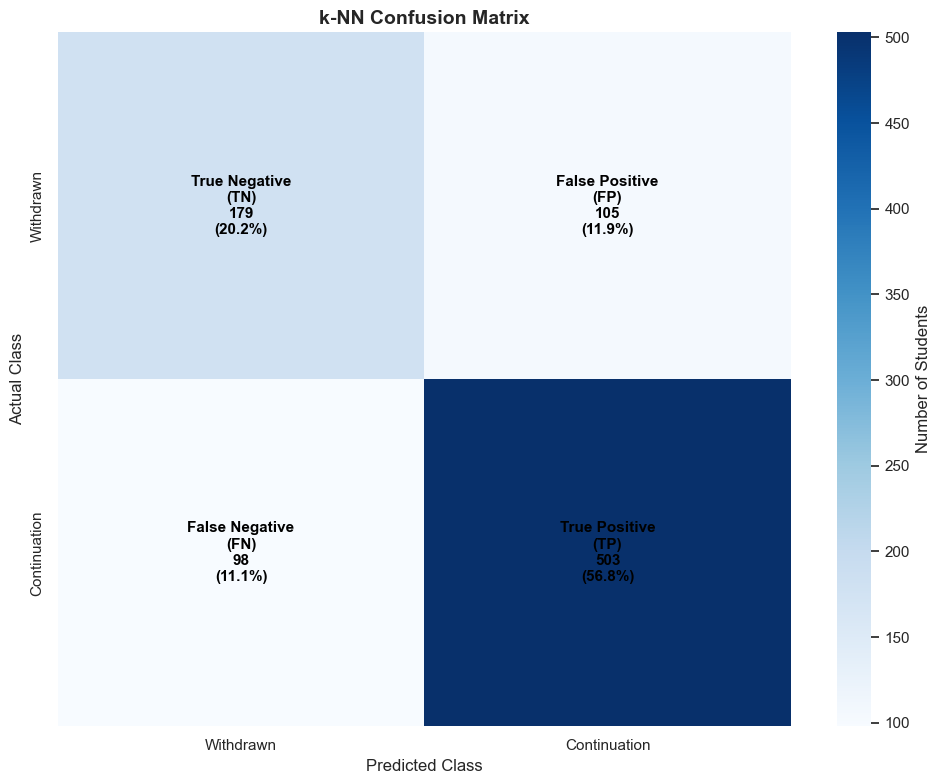


Confusion Matrix Interpretation:
True Negatives (Correctly predicted withdrawn):  179
False Positives (Predicted continuation, actually withdrew): 105
False Negatives (Predicted withdrawal, actually continued): 98
True Positives (Correctly predicted continuation): 503

Key Insights:
Total Misclassifications: 203 out of 885 (22.9%)
More concerning errors: False Positives (105 students)


In [416]:
def plot_confusion_matrix(results, figsize=(10, 8)):
    """
    Plot confusion matrix with detailed labels including TP/TN/FP/FN.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from evaluate_knn_model()
    figsize : tuple
        Figure size for the plot
    """
    
    cm = results['confusion_matrix']
    class_names = results['class_names']
    
    plt.figure(figsize=figsize)
    
    # Create heatmap without annotations first
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Students'})
    
    plt.title('k-NN Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('Actual Class', fontsize=12)
    
    # Define labels for each quadrant
    labels = [['True Negative\n(TN)', 'False Positive\n(FP)'],
              ['False Negative\n(FN)', 'True Positive\n(TP)']]
    
    # Add custom annotations with labels, counts, and percentages
    total = cm.sum()
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            count = cm[i, j]
            percentage = count / total * 100
            
            # Create multi-line annotation
            annotation = f'{labels[i][j]}\n{count}\n({percentage:.1f}%)'
            
            plt.text(j + 0.5, i + 0.5, annotation, 
                    ha='center', va='center', fontsize=11, 
                    fontweight='bold', color='black')
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    tn, fp, fn, tp = cm.ravel()
    print(f'\nConfusion Matrix Interpretation:')
    print(f'True Negatives (Correctly predicted withdrawn):  {tn}')
    print(f'False Positives (Predicted continuation, actually withdrew): {fp}')
    print(f'False Negatives (Predicted withdrawal, actually continued): {fn}')
    print(f'True Positives (Correctly predicted continuation): {tp}')
    
    # Calculate and print key insights
    total_errors = fp + fn
    print(f'\nKey Insights:')
    print(f'Total Misclassifications: {total_errors} out of {total} ({total_errors/total*100:.1f}%)')
    print(f'More concerning errors: {"False Negatives" if fn > fp else "False Positives"} ({max(fn,fp)} students)')
    
    return None  # Explicitly return None since this is a plotting function

# Plot the confusion matrix
plot_confusion_matrix(results)

In [417]:
def analyse_misclassifications(results, X_test, feature_names):
    """
    Analyse which students were misclassified and why.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from evaluate_knn_model()
    X_test : array-like
        Test features (scaled)
    feature_names : list
        Names of the features
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with misclassified samples and their characteristics
    """
    
    y_pred = results['predictions']
    y_actual = results['actual']
    y_proba = results['prediction_probabilities']
    
    # Find misclassified samples
    misclassified_mask = y_pred != y_actual
    misclassified_indices = np.where(misclassified_mask)[0]
    
    if len(misclassified_indices) == 0:
        print('No misclassifications found!')
        return pd.DataFrame()
    
    print(f'\nAnalysing {len(misclassified_indices)} misclassified students...')
    
    # Create DataFrame with misclassified samples
    misclassified_df = pd.DataFrame()
    misclassified_df['actual'] = y_actual[misclassified_mask]
    misclassified_df['predicted'] = y_pred[misclassified_mask]
    misclassified_df['prediction_confidence'] = np.abs(y_proba[misclassified_mask] - 0.5) + 0.5
    
    # Create DataFrame from X_test and use iloc for position-based indexing
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
    
    # Add feature values using iloc (position-based) instead of loc (label-based)
    for feature in feature_names:
        misclassified_df[feature] = X_test_df.iloc[misclassified_indices][feature].values
    
    # Categorise misclassification types
    false_positives = misclassified_df[misclassified_df['actual'] == 0]  # Predicted continuation, actually withdrew
    false_negatives = misclassified_df[misclassified_df['actual'] == 1]  # Predicted withdrawal, actually continued
    
    print(f'False Positives (predicted continuation, actually withdrew): {len(false_positives)}')
    print(f'False Negatives (predicted withdrawal, actually continued): {len(false_negatives)}')
    
    # Analyse confidence levels
    low_confidence = misclassified_df[misclassified_df['prediction_confidence'] < 0.6]
    print(f'Low confidence misclassifications (<60%): {len(low_confidence)}')
    
    # Add interpretation labels for clarity
    misclassified_df['error_type'] = misclassified_df['actual'].map({
        0: 'False Positive (Missed withdrawal)',
        1: 'False Negative (Predicted withdrawal incorrectly)'
    })
    
    # Sort by confidence level (lowest first - most uncertain predictions)
    misclassified_df = misclassified_df.sort_values('prediction_confidence')
    
    return misclassified_df

misclassified_df = analyse_misclassifications(results, X_test, X_train.columns.tolist())


Analysing 203 misclassified students...
False Positives (predicted continuation, actually withdrew): 105
False Negatives (predicted withdrawal, actually continued): 98
Low confidence misclassifications (<60%): 66


In [418]:
def generate_model_summary(results, knn_config, optimal_k, X_train):
    """Generate comprehensive model summary for reporting."""
    
    # Get actual feature count from training data
    actual_feature_count = X_train.shape[1]
    
    summary = {
        'model_type': 'k-Nearest Neighbours',
        'hyperparameters': {
            'k_neighbors': optimal_k,
            'scaler_type': knn_config.get('scaler_type'),
            'train_size': knn_config.get('train_size'),
            'cv_folds': knn_config.get('cv'),
            'k_search_range': knn_config.get('n_neighbors_range')
        },
        'performance_metrics': {
            'accuracy': results['accuracy'],
            'precision': results['precision'],
            'recall': results['recall'],
            'withdrawal_recall': results['withdrawal_recall'],
            'f1_score': results['f1_score'],
            'auc_roc': results['auc_roc'],
            'true_specificity': results['true_specificity'],
            'sensitivity': results['sensitivity']
        },
        'confusion_matrix': results['confusion_matrix'].tolist(),
        'test_samples': len(results['actual']),
        'feature_count': actual_feature_count
    }
    
    return summary

# Extract optimal k from best parameters
optimal_k = best_params['classifier__n_neighbors']

# Generate model summary with correct parameters
summary = generate_model_summary(results, knn_config, optimal_k, X_train)
summary

{'model_type': 'k-Nearest Neighbours',
 'hyperparameters': {'k_neighbors': 4,
  'scaler_type': 'standard',
  'train_size': 0.8,
  'cv_folds': 10,
  'k_search_range': [3, 10]},
 'performance_metrics': {'accuracy': 0.7706214689265537,
  'precision': 0.8273026315789473,
  'recall': 0.8369384359400999,
  'withdrawal_recall': 0.6302816901408451,
  'f1_score': 0.8320926385442514,
  'auc_roc': np.float64(0.794397834594924),
  'true_specificity': np.float64(0.6302816901408451),
  'sensitivity': np.float64(0.8369384359400999)},
 'confusion_matrix': [[179, 105], [98, 503]],
 'test_samples': 885,
 'feature_count': 10}

Testing 50 seeds: [6490 9929 9815 2628 4709]...
Running... Done!
          Metric  Value
0           Mean  0.640
1        Std Dev  0.028
2            Min  0.585
3            Max  0.704
4          Range  0.120
5             CV  0.043
6  Most Common k      4


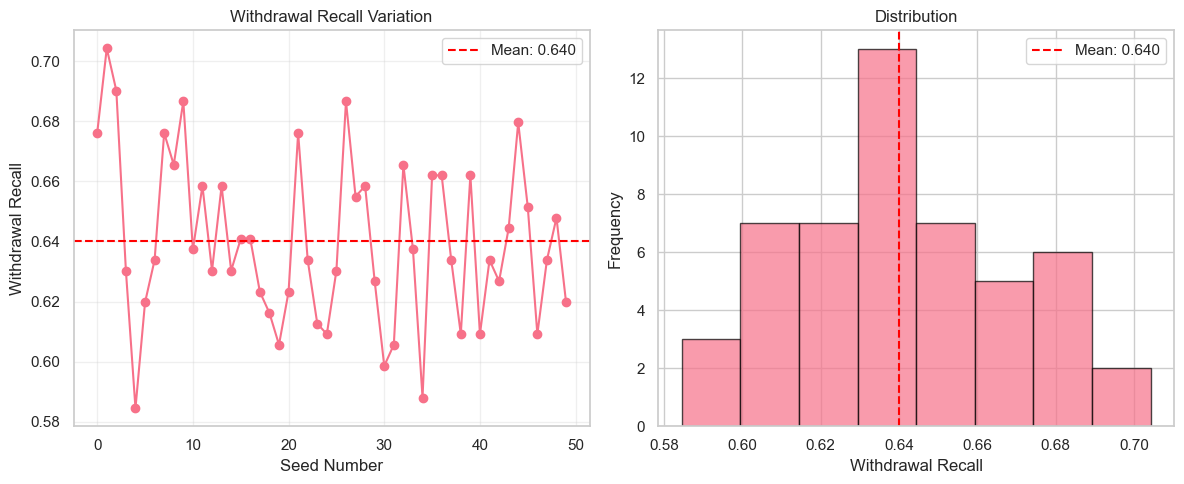

In [419]:
def test_withdrawal_recall_with_seeds(df_dataset, knn_config, n_seeds=10, use_fixed_seeds=False):
    """
    Test withdrawal recall stability across different random seeds.
    Returns a neat summary dataframe instead of verbose output.
    
    Parameters:
    -----------
    use_fixed_seeds : bool, default=False
        If True, uses same seeds each time (reproducible). 
        If False, generates new random seeds each run.
    """
    
    # Generate random seeds
    if use_fixed_seeds:
        np.random.seed(42)  # Reproducible seeds
    seeds = np.random.randint(1, 10000, n_seeds)
    
    print(f"Testing {n_seeds} seeds: {seeds[:5]}{'...' if n_seeds > 5 else ''}")
    print("Running...", end=' ')
    
    results = []
    
    for seed in seeds:
        # Split data with current seed
        X = df_dataset.drop('target_binary', axis=1)
        y = df_dataset['target_binary']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=0.8, random_state=seed, stratify=y
        )
        
        # Apply withdrawal rate encoding
        def calculate_withdrawal_rates_training_only(X_train, y_train, categorical_col):
            train_df = X_train.copy()
            train_df['target_binary'] = y_train
            withdrawal_rates = train_df.groupby(categorical_col)['target_binary'].agg(['count', 'sum'])
            withdrawal_rates['withdrawal_rate'] = 1 - (withdrawal_rates['sum'] / withdrawal_rates['count'])
            return withdrawal_rates['withdrawal_rate'].to_dict()
        
        course_rates = calculate_withdrawal_rates_training_only(X_train, y_train, 'course')
        application_mode_rates = calculate_withdrawal_rates_training_only(X_train, y_train, 'application_mode')
        
        overall_withdrawal_rate = 1 - y_train.mean()
        
        X_train['course_withdrawal_rate'] = X_train['course'].map(course_rates)
        X_train['application_mode_withdrawal_rate'] = X_train['application_mode'].map(application_mode_rates)
        
        X_test['course_withdrawal_rate'] = X_test['course'].map(course_rates)
        X_test['application_mode_withdrawal_rate'] = X_test['application_mode'].map(application_mode_rates)
        
        X_test = X_test.fillna({
            'course_withdrawal_rate': overall_withdrawal_rate, 
            'application_mode_withdrawal_rate': overall_withdrawal_rate
        })
        
        X_train = X_train.drop(columns=['course', 'application_mode'])
        X_test = X_test.drop(columns=['course', 'application_mode'])
        
        # Define preprocessing pipeline
        numeric_cols = ['application_order', 'admission_grade', 'age_at_enrollment', 
                       'curricular_units_1st_sem_grade', 'course_withdrawal_rate', 
                       'application_mode_withdrawal_rate']
        binary_cols = ['tuition_fees_up_to_date', 'scholarship_holder', 
                      'parental_higher_education', 'parental_professional_occupation']
        
        preprocessor = ColumnTransformer([
            ('numeric', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler() if knn_config.get('scaler_type') == 'minmax' else StandardScaler())
            ]), numeric_cols),
            ('binary', 'passthrough', binary_cols)
        ], remainder='drop')
        
        # Create model pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('selector', SelectKBest(score_func=mutual_info_classif, k='all')),
            ('classifier', KNeighborsClassifier())
        ])
        
        # Simple parameter grid
        k_min, k_max = knn_config['n_neighbors_range']
        param_grid = {
            'classifier__n_neighbors': list(range(k_min, k_max + 1)),
            'classifier__weights': ['uniform']
        }
        
        # Grid search
        withdrawal_recall_scorer = make_scorer(recall_score, pos_label=0, greater_is_better=True)
        grid_search = GridSearchCV(
            pipeline, param_grid, scoring=withdrawal_recall_scorer, 
            cv=3, n_jobs=-1, verbose=0
        )
        
        grid_search.fit(X_train, y_train)
        
        # Evaluate on test set
        y_pred = grid_search.predict(X_test)
        withdrawal_recall = recall_score(y_test, y_pred, pos_label=0)
        
        results.append({
            'seed': seed,
            'best_k': grid_search.best_params_['classifier__n_neighbors'],
            'withdrawal_recall': withdrawal_recall,
            'accuracy': accuracy_score(y_test, y_pred)
        })
    
    print("Done!")
    
    # Create summary dataframe
    results_df = pd.DataFrame(results)
    wr = results_df['withdrawal_recall']
    
    summary = pd.DataFrame({
        'Metric': ['Mean', 'Std Dev', 'Min', 'Max', 'Range', 'CV', 'Most Common k'],
        'Value': [
            f"{wr.mean():.3f}",
            f"{wr.std():.3f}", 
            f"{wr.min():.3f}",
            f"{wr.max():.3f}",
            f"{wr.max() - wr.min():.3f}",
            f"{wr.std()/wr.mean():.3f}",
            f"{results_df['best_k'].mode().iloc[0]}"
        ]
    })
    
    return summary, results_df


def plot_seed_results(results_df):
    """Simple plot of withdrawal recall across seeds."""
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(len(results_df)), results_df['withdrawal_recall'], 'o-')
    plt.axhline(results_df['withdrawal_recall'].mean(), color='red', linestyle='--', 
                label=f'Mean: {results_df["withdrawal_recall"].mean():.3f}')
    plt.xlabel('Seed Number')
    plt.ylabel('Withdrawal Recall')
    plt.title('Withdrawal Recall Variation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(results_df['withdrawal_recall'], bins=8, alpha=0.7, edgecolor='black')
    plt.axvline(results_df['withdrawal_recall'].mean(), color='red', linestyle='--', 
                label=f'Mean: {results_df["withdrawal_recall"].mean():.3f}')
    plt.xlabel('Withdrawal Recall')
    plt.ylabel('Frequency')
    plt.title('Distribution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# For different results each time:
summary, results_df = test_withdrawal_recall_with_seeds(df_dataset, knn_config, n_seeds=50)

print(summary)
plot_seed_results(results_df) 

MinMax: Withdrawal Recall=0.553, Accuracy=0.799
Standard: Withdrawal Recall=0.560, Accuracy=0.805
Robust: Withdrawal Recall=0.556, Accuracy=0.802


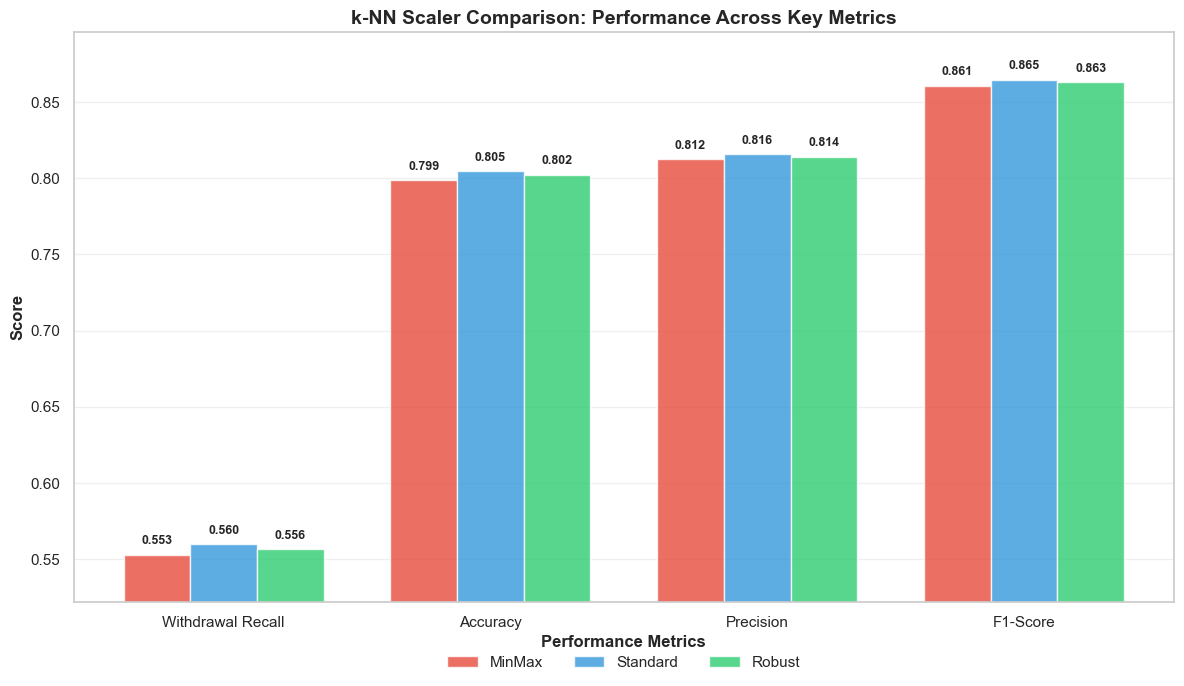


🏆 Winner: Standard
Withdrawal Recall: 0.560
Improvement: +0.007


In [420]:
def scalers_test(X_train, X_test, y_train, y_test):
    """Test MinMax vs Standard vs Robust scalers with clustered bar chart."""
        
    # Set seaborn theme
    sns.set_theme(style="whitegrid", palette="husl")
    
    results = {}
    
    for name, scaler in [('MinMax', MinMaxScaler()), ('Standard', StandardScaler()), ('Robust', RobustScaler())]:
        
        # Scale numeric features only
        numeric_cols = [0, 1, 2, 3, 4, 5]  # First 6 columns are numeric
        
        # Convert to float to avoid warnings
        X_train_scaled = X_train.astype(float)
        X_test_scaled = X_test.astype(float)
        
        X_train_scaled.iloc[:, numeric_cols] = scaler.fit_transform(X_train_scaled.iloc[:, numeric_cols])
        X_test_scaled.iloc[:, numeric_cols] = scaler.transform(X_test_scaled.iloc[:, numeric_cols])
        
        # Simple k-NN with k=5
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)
        
        # Calculate all metrics
        withdrawal_recall = recall_score(y_test, y_pred, pos_label=0)  # Specificity
        continuation_recall = recall_score(y_test, y_pred, pos_label=1)  # Sensitivity
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results[name] = {
            'Withdrawal Recall': withdrawal_recall,
            'Accuracy': accuracy,
            'Precision': precision,
            'F1-Score': f1
        }
        
        print(f"{name}: Withdrawal Recall={withdrawal_recall:.3f}, Accuracy={accuracy:.3f}")
    
    # Create DataFrame for plotting
    df = pd.DataFrame(results).T
    
    # Create clustered bar chart
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Set up the bars - metrics on x-axis, scalers as bars
    metrics = df.columns
    scalers = df.index
    x = np.arange(len(metrics))
    width = 0.25  # Narrower bars for 3 scalers
    colors = ['#e74c3c', '#3498db', '#2ecc71']  # Red, Blue, Green
    
    # Plot bars for each scaler
    for i, (scaler, color) in enumerate(zip(scalers, colors)):
        offset = (i - 1) * width  # Center the 3 bars around each metric
        bars = ax.bar(x + offset, df.loc[scaler], width, label=scaler, color=color, alpha=0.8)
        
        # Add value labels on bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Customise chart
    ax.set_xlabel('Performance Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('k-NN Scaler Comparison: Performance Across Key Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)


    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=3, frameon=False)
    
    # Set y-axis limits: 10% below min, 10% above max
    data_min = df.min().min()
    data_max = df.max().max()
    y_range = data_max - data_min
    ax.set_ylim(data_min - 0.1 * y_range, data_max + 0.1 * y_range)
    
    # Remove gridlines
    ax.grid(True, axis='y', alpha=0.3)  # Only horizontal gridlines
    ax.grid(False, axis='x')            # No vertical gridlines
    
    # Highlight the winner for withdrawal recall
    winner_idx = df['Withdrawal Recall'].idxmax()
    winner_scaler = df.index[df.index == winner_idx][0]
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n🏆 Winner: {winner_scaler}")
    print(f"Withdrawal Recall: {df.loc[winner_scaler, 'Withdrawal Recall']:.3f}")
    print(f"Improvement: +{(df['Withdrawal Recall'].max() - df['Withdrawal Recall'].min()):.3f}")
    
    return df, winner_scaler

results, winner = scalers_test(X_train, X_test, y_train, y_test)